# Machine Learning

In [2]:
import pandas as pd
import numpy as numpy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Cargar datos limpios

In [4]:
# Cargar datos limpios
ratings_original = pd.read_csv(r"../data/process/rating.csv")

In [5]:
ratings_original["timestamp"] = pd.to_datetime(ratings_original["timestamp"])

In [6]:
YEAR_FILTER = ratings_original["timestamp"].dt.year.max()

In [7]:
YEAR_FILTER

np.int32(2015)

In [8]:
ratings = ratings_original[ratings_original["timestamp"].dt.year >= YEAR_FILTER]

In [ ]:
# Numero de usuarios que votaron por cada pelicula
no_user_voted = ratings.groupby('movieid')['rating'].agg('count')
no_user_voted.head()

movieid
1    437
2    164
3     24
4      6
5     38
Name: rating, dtype: int64

In [ ]:
# Numero de peliculas que voto cada usuario
no_movies_voted = ratings.groupby('userid')['rating'].agg('count')
no_movies_voted.head()

userid
31     246
96      70
176     25
215      8
260     78
Name: rating, dtype: int64

In [9]:
movies = pd.read_csv(r"../data/process/movie.csv")

In [10]:
tags = pd.read_csv(r"../data/process/tag.csv")

In [11]:
tags["timestamp"] = pd.to_datetime(tags["timestamp"])

In [12]:
tags = tags[tags["timestamp"].dt.year >= YEAR_FILTER]

In [13]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19866 entries, 301 to 464452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userid     19866 non-null  int64         
 1   movieid    19866 non-null  int64         
 2   tag        19866 non-null  object        
 3   timestamp  19866 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 776.0+ KB


In [18]:
ratings_original.shape


(20000263, 4)

In [17]:
ratings.shape

(283886, 4)

In [42]:
no_user_voted = ratings.groupby('movieid')['rating'].agg('count')
no_movies_voted = ratings.groupby('userid')['rating'].agg('count')

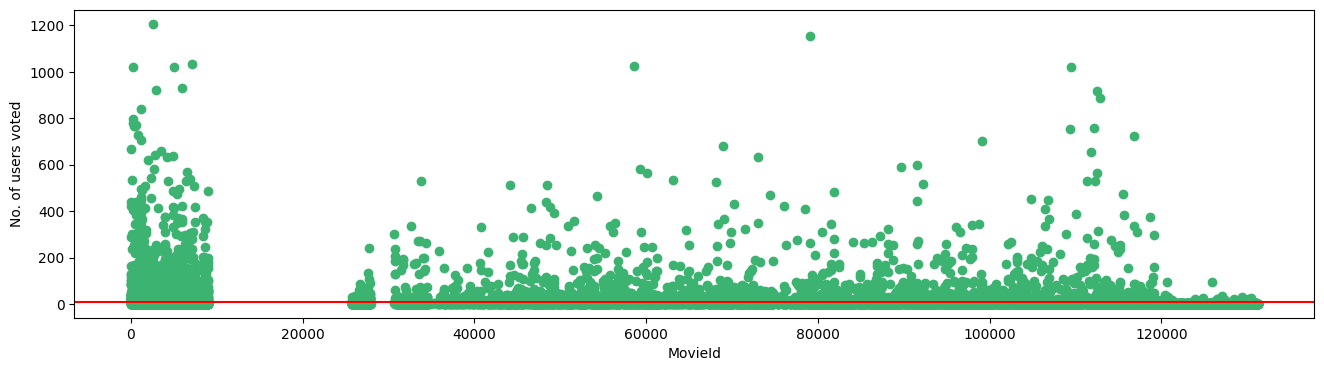

In [44]:
# Visualicemos el número de usuarios que votaron con nuestro umbral de 10.
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

# **Sistemas de Recomendación**
Los sistemas de recomendación son algoritmos que filtran y predicen las preferencias del usuario para sugerirle elementos (productos, películas, noticias, etc.) que probablemente le interesen.

**¿Cómo funciona?** Pueden usar enfoques de filtrado colaborativo (basado en el comportamiento de usuarios similares), filtrado basado en contenido (basado en atributos del ítem) o una combinación híbrida para generar sugerencias personalizadas.

**Ejemplos de aplicación:**

- Recomendaciones de productos en plataformas de ecommerce (Amazon, Mercado Libre).
- Sugerencias de películas y series en servicios de streaming (Netflix, HBO Max).
- Personalización de noticias y artículos en plataformas de contenido (Google News, Facebook).
- Recomendaciones musicales (Spotify).

**Algoritmos comunes:** Filtrado Colaborativo (basado en usuario/ítem), Factorización Matricial (SVD, ALS), Modelos
basados en Redes Neuronales (Deep Learning), Algoritmos de Reglas de Asociación.

**Ventajas y casos de uso:** Mejoran la experiencia del usuario, aumentan el engagement y las ventas al presentar contenido relevante. Son omnipresentes en plataformas digitales y de comercio electrónico.

## Tecnicas a utilizar
- Filtrado colaborativo con **sklearn**
   1. Generar una matriz de usuarios y peliculas
   2. Calcular la similitud entre usuarios usando la *similitud del coseno*
   3. Identificar usuarios con mas similitudes o parecidos y se promedia las peliculas que calificaron 
- Reglas de asociación con **mlxtend**

   4. Transformar los tags por cada película en transacciones (una película 1:M un conjunto de tags). 
   5. Añadir una columna que especial por película para poder generar reglas como:"si tiene estos tags, entonces recomienda esta película".
   6. Se aplica el algoritmo `Apriori` para encontrar conjuntos frecuentes de tags + películas, y luego se generan reglas de asociación con métricas como lift y support.
   7. Dado un conjunto de tags de entrada, se filtran las reglas cuyos antecedentes los contienen y se extraen las películas recomendadas.
    

### Filtrado Colaborativo
#### 1.  Generar una matriz de usuarios y peliculas

In [38]:
user_movie_matrix = ratings.pivot(index='userid', columns='movieid', values='rating').fillna(0)

In [39]:
user_movie_matrix.head()

movieid,1,2,3,4,5,6,7,8,9,10,...,131241,131243,131248,131250,131252,131254,131256,131258,131260,131262
userid,,,,,,,,,,,,,,,,,,,,,
31,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
user_movie_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3903 entries, 31 to 138414
Columns: 14639 entries, 1 to 131262
dtypes: float64(14639)
memory usage: 435.9 MB


#### 2.  Usamos KNN con similitud coseno sobre la matriz usuario-película. 
K-Nearest Neighbors (KNN) - Busqueda de vecinos mas cercanos 

- Vectores similares obtendran 1
- Vectores diferentes obtienen una puntuacion de 0

In [ ]:
user_sim = cosine_similarity(user_movie_matrix)
user_sim_df = pd.DataFrame(user_sim, index=user_movie_matrix.index, columns=user_movie_matrix.index)
user_sim_df

userid,31,96,176,215,260,279,284,318,342,370,...,51558,51567,51587,51589,51616,51650,51660,51663,51703,51745
userid,,,,,,,,,,,,,,,,,,,,,
31,1.000000,0.147473,0.157599,0.002983,0.067437,0.0,0.118751,0.303288,0.000000,0.055971,...,0.051363,0.207130,0.0,0.096950,0.045719,0.096174,0.172316,0.038771,0.004320,0.000000
96,0.147473,1.000000,0.000000,0.000000,0.050610,0.0,0.070207,0.137240,0.059776,0.013512,...,0.042330,0.021530,0.0,0.022763,0.000000,0.027794,0.066368,0.040748,0.017535,0.000000
176,0.157599,0.000000,1.000000,0.000000,0.016558,0.0,0.057756,0.074389,0.000000,0.000000,...,0.012550,0.098659,0.0,0.126154,0.000000,0.113214,0.060075,0.048942,0.000000,0.000000
215,0.002983,0.000000,0.000000,1.000000,0.004451,0.0,0.000000,0.033986,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.025525,0.020592,0.000000,0.000000
260,0.067437,0.050610,0.016558,0.004451,1.000000,0.0,0.217583,0.171974,0.038453,0.029801,...,0.039443,0.136853,0.0,0.185764,0.034516,0.098159,0.180692,0.280071,0.110499,0.060401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51650,0.096174,0.027794,0.113214,0.000000,0.098159,0.0,0.184599,0.108107,0.036516,0.087872,...,0.001928,0.213361,0.0,0.234165,0.040456,1.000000,0.157100,0.082202,0.000000,0.041006
51660,0.172316,0.066368,0.060075,0.025525,0.180692,0.0,0.117648,0.219248,0.000000,0.023543,...,0.052821,0.166247,0.0,0.103040,0.013850,0.157100,1.000000,0.107876,0.008729,0.013161
51663,0.038771,0.040748,0.048942,0.020592,0.280071,0.0,0.163496,0.173207,0.000000,0.055054,...,0.035522,0.119974,0.0,0.140104,0.000000,0.082202,0.107876,1.000000,0.033726,0.059456


In [35]:
# funcion para recomendar dependiendo el usuario
def recommend_collaborative(userid, n=10):
    similar_users = user_sim_df[userid].sort_values(ascending=False).index[1:6]  # top 5 similares
    
    # Películas que esos usuarios vieron y userid no
    watched = set(ratings[ratings['userid'] == userid]['movieid'])
    candidates = ratings[ratings['userid'].isin(similar_users)]
    candidates = candidates[~candidates['movieid'].isin(watched)]
    recs = candidates.groupby('movieid')['rating'].mean().sort_values(ascending=False).head(n)
    return recs.index.tolist()

#### Asociación de tags con las peliculas

In [61]:
# Agrupar tags por película
tags_grouped = tags.groupby('movieid')['tag'].apply(list).reset_index()

In [62]:
tags_grouped.head()

,movieid,tag
0,1,"[animation, friendship, toys, familyfilm, frie..."
1,5,"[Comedy, Touching]"
2,6,"[esunpocdelodesempre, AlPacino, bankrobbery, c..."
3,10,[Bobola]
4,16,[casino]


In [63]:
# Codificar transacciones (tags por película)
te = TransactionEncoder()
te_ary = te.fit(tags_grouped['tag']).transform(tags_grouped['tag'])
tag_matrix = pd.DataFrame(te_ary, columns=te.columns_, index=tags_grouped['movieid']).reset_index()

In [64]:
tag_matrix.head(5)

,movieid,007series,0115,0215,0315,100GreatestMovies,100greatestmovies,12yearsinthemaking,16thcentury,17thcentury,...,youngparents,youth,youwillloveit,zef,zeitgeisty,zimbabwe,zizekspick,zombie,zombies,zzzzzzzzzzzzzz
0,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,6,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,16,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
# Añadir "película_X" como ítem para asociar tags a película
for mid in tag_matrix['movieid']:
    tag_matrix[f"movie_{mid}"] = 0
    tag_matrix.loc[tag_matrix['movieid'] == mid, f"movie_{mid}"] = 1

In [68]:
tag_matrix.head()

,movieid,007series,0115,0215,0315,100GreatestMovies,100greatestmovies,12yearsinthemaking,16thcentury,17thcentury,...,movie_130984,movie_131011,movie_131013,movie_131015,movie_131031,movie_131054,movie_131082,movie_131164,movie_131170,movie_131258
0,1,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,5,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,6,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,10,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,16,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Eliminar columna original de movieid
tag_matrix = tag_matrix.drop('movieid', axis=1)

In [70]:
tag_matrix.head()

,007series,0115,0215,0315,100GreatestMovies,100greatestmovies,12yearsinthemaking,16thcentury,17thcentury,1800s,...,movie_130984,movie_131011,movie_131013,movie_131015,movie_131031,movie_131054,movie_131082,movie_131164,movie_131170,movie_131258
0,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Aplicar Apriori
frequent_itemsets = apriori(tag_matrix, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

d:\Personal\UNIANDES\OneDrive\OneDrive - UNIANDES\SEMINARIO\Proyecto\seminario-complexivo-grupo8\venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [80]:
rules['consequents'] = rules['consequents'].apply(lambda x: list(x))
movie_rules = rules[rules['consequents'].apply(lambda x: any('movie_' in str(i) for i in x))]

In [74]:
# Ej: reglas con tags → película
def recommend_association(input_tags, n=10):
    input_set = set(input_tags)
    relevant = movie_rules[movie_rules['antecedents'].apply(lambda x: input_set.issubset(x))]
    movies = relevant['consequents'].apply(lambda x: [i for i in x if 'movie_' in str(i)])
    movie_ids = [int(m.replace('movie_', '')) for sublist in movies for m in sublist]
    return list(set(movie_ids))[:n]

In [75]:
def hybrid_recommend(userid, input_tags, n=10):
    collab = recommend_collaborative(userid, n*2)
    assoc = recommend_association(input_tags, n*2)
    # Intersección primero, luego unión
    common = list(set(collab) & set(assoc))
    union = list(set(collab + assoc))
    recs = common + [m for m in union if m not in common]
    return recs[:n]

Evaluacion de funciones

In [77]:
print(f"Películas: {movies.shape}")
print(f"Calificaciones: {ratings.shape}")
print(f"Tags: {tags.shape}")

Películas: (27278, 3)
Calificaciones: (106362, 4)
Tags: (19866, 4)


In [97]:
# 2. Probar recomendación colaborativa (elige un userid que exista)
test_user = ratings['userid'].iloc[0]
print(f"Recomendación colaborativa para usuario {test_user}")
collab_recs = recommend_collaborative(test_user, n=10)
print(collab_recs)

Recomendación colaborativa para usuario 31
[246, 71264, 60487, 71462, 1080, 69757, 85736, 88129, 57274, 1580]


In [98]:
a = movies[movies["movieid"].isin(collab_recs)]
a

,movieid,title,genres
243,246,Hoop Dreams (1994),Documentary
1058,1080,Monty Python's Life of Brian (1979),Comedy
1528,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi
12364,57274,REC (2007),Drama|Horror|Thriller
12826,60487,"It's the Great Pumpkin, Charlie Brown (1966)",Animation|Children|Comedy
13916,69757,(500) Days of Summer (2009),Comedy|Drama|Romance
14209,71264,Cloudy with a Chance of Meatballs (2009),Animation|Children|Fantasy|IMAX
14257,71462,"Cove, The (2009)",Documentary
16936,85736,BURNE (2008),Adventure|Animation|Children|Sci-Fi
17501,88129,Drive (2011),Crime|Drama|Film-Noir|Thriller


In [83]:
# 3. Probar reglas de asociación (elige tags reales)
sample_tags = tags['tag'].value_counts().index[:2].tolist()  # 2 tags más comunes
# print("\nRecomendación por asociación con tags:", sample_tags)
# assoc_recs = recommend_association(sample_tags, n=5)
# print(assoc_recs)

In [84]:
# 4. Probar sistema híbrido
print("\nRecomendación híbrida:")
hybrid_recs = hybrid_recommend(test_user, sample_tags, n=5)
print(hybrid_recs)


Recomendación híbrida:


KeyError: 'antecedents'